# <div align="center">Project Status</div>
### <div align="center">Nico Braukman - 7/20/2021</div>

## <div align="center">Introduction</div>
**Objective:** Train an algorithm to identify real (prompt) vs. fake photons, training on $tt\gamma$, $t\bar{t}$ events.

Similar to the MVA ID score, but trained on a different class of events.

### Tools:
* **Coffea:** process event data (MC and CMS)
* **Scikit-learn:** scale and split training data
* **Keras:** build, fit, evaluate model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from coffea import hist, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import uproot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

## <div align="center">Processing Data With Coffea</div>
The processor:
* performs cuts on the data.
* fills `hist` histograms to visualize features.
* fills `column_accumulator`s with data passed to the model.

## <div align="center">Object Selection</div>
**Muons:**
```
events.Muon.pt > 30 &
abs(events.Muon.eta) < 2.4 &
events.Muon.tightId &
events.Muon.pfRelIso04_all < 0.15
```
***

**Jets:**
```
events.Jet.pt > 30 &
abs(events.Jet.eta) < 2.4 &
events.Jet.isTight
```
b-tagged jets also have `events.Jet.btagDeepB > 0.6321`.
***

**Electrons:**
```
events.Electron.pt > 35 &
abs(events.Electron.eta) < 2.1 &
events.Electron.cutBased >= 4
```
***

**Photons:**

First, calculate $\Delta R$ for photons & muons, photons & jets
using the `nearest` function:
```
phoMu, phoMuDR = events.Photon.nearest(tightMuons,...
                  return_metric=True)
phoMuMask = ak.fill_none(phoMuDR>0.4,True)

phoJet, phoJetDR = events.Photon.nearest(tightJets,...
                    return_metric=True)
phoJetMask = ak.fill_none(phoJetDR>0.4,True)
```

Use these masks to remove low-$\Delta R$ photons in the selection:
```
events.Photon.pt > 20 &
abs(events.Photon.eta) < 1.4442 &
(events.Photon.isScEtaEE | events.Photon.isScEtaEB) &
events.Photon.electronVeto &
np.invert(events.Photon.pixelSeed) &
phoMuMask &
phoJetMask
```
***

## <div align="center">Event Selection</div>
```
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons) == 1) &
                  (ak.num(tightJets) >= 4) & 
                  (ak.num(tightBJets) >= 1) &
                  (ak.num(tightEle) == 0) &
                  (ak.num(tightPhotons) >= 1)
                  )
```

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        # data is/isn't Monte-Carlo
        self.isMC = isMC

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","$\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","pfRelIso03_all", 40, -0.5, 2)
        photon_reliso_chg_axis = hist.Bin("reliso","pfRelIso03_chg", 40, -0.5, 2)
        photon_sieie_axis = hist.Bin("sieie","$\sigma_{i\eta i\eta}$", 40, 0, 0.03)
        photon_r9_axis = hist.Bin("r9","R9", 40, 0, 1.5)
        photon_hoe_axis = hist.Bin("hoe","H over E", 40, -0.1, 0.4)

        mu_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-muon", 50, -0.5, 4)
        jet_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-jet", 50, -0.5, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
            'file': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, mu_deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, jet_deltar_axis),
            
            'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # delta R cuts
        phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
        phoMuMask = ak.fill_none(phoMuDR>0.4,True)
        
        phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
        phoJetMask = ak.fill_none(phoJetDR>0.4,True)
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed) &
                       phoMuMask & phoJetMask
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        # fill histograms
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
        output['photon_eta_hist'].fill(dataset=dataset,
                                       eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
        output['photon_phi_hist'].fill(dataset=dataset,
                                       phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                         sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                       hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                                 deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                              deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid_hist'].fill(dataset=dataset,
                                         mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
        if self.isMC:
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        
        # fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
            
        # dataset labels
        if dataset=='TTGamma':
            output['file'] = processor.column_accumulator(np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        elif dataset=='TTbar':
            output['file'] = processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        else:
            output['file'] = processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)
        

# Monte-Carlo events
outputMC = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)

# Data events
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

## <div align="center">Features</div>
Ten total photon features.

Kinematic features:
* $p_T$ (pt)
* $\eta$ (eta)
* $\phi$ (phi)

`hoe`: H over E, HCAL energy / ECAL energy

Isolation & shower-shape features:
* `pfRelIso03_all`: PF relative isolation dR=0.3, total (with rho*EA PU corrections)
* `pfRelIso03_chg`: PF relative isolation dR=0.3, charged component (with rho*EA PU corrections)
* `sieie`: sigma_IetaIeta of the supercluster, calculated with full 5x5 region
* `r9`: R9 of the supercluster, calculated with full 5x5 region
* $\Delta R = \sqrt{\Delta\eta^2 + \Delta\phi^2}$ between each photon and the nearest muon
* $\Delta R$ between each photon and the nearest jet

Target: `genPartFlav`, Flavour of genParticle for MC matching to status==1 photons or electrons:
* 1 = prompt photon
* 11 = prompt electron (relabeled as 0 for training)
* 0 = unknown or unmatched

## <div align="center">Feature Distributions</div>

### <div align="center">Photon $p_T$</div>

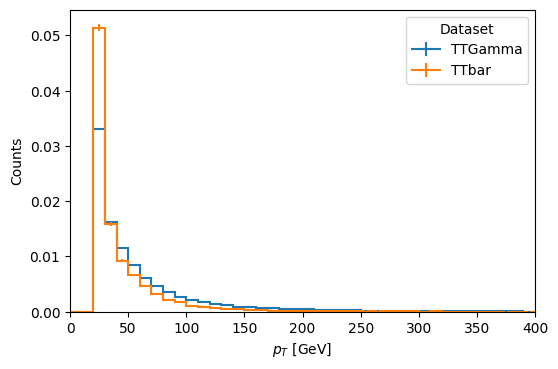

In [5]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon $\eta$</div>

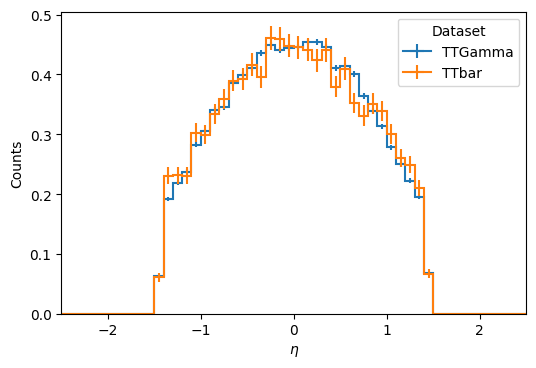

In [6]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_eta_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon $\phi$</div>

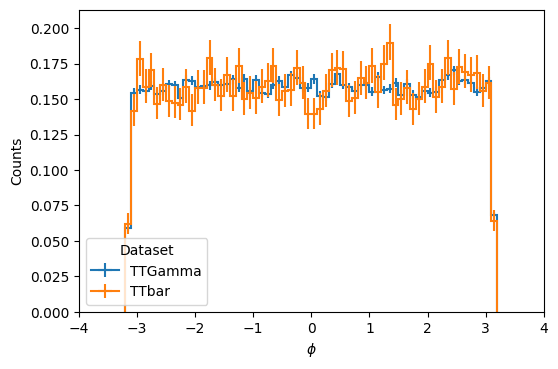

In [7]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_phi_hist'],overlay='dataset',stack=False,density=True)
plt.xlim(-4,4)
plt.show()

### <div align="center">Photon Relative Isolation (total)</div>

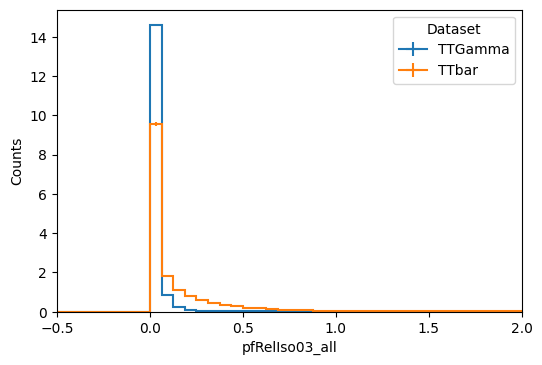

In [8]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_all_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon Relative Isolation (charge)</div>

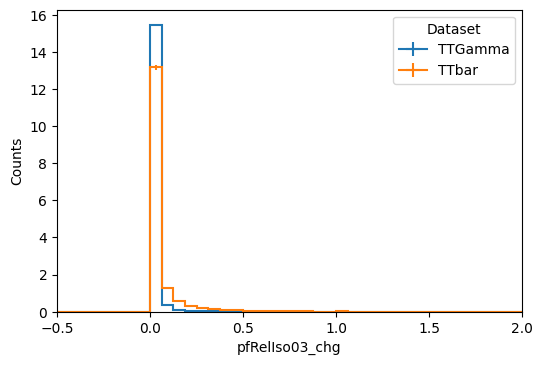

In [9]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_chg_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon $\sigma_{i\eta i\eta}$</div>

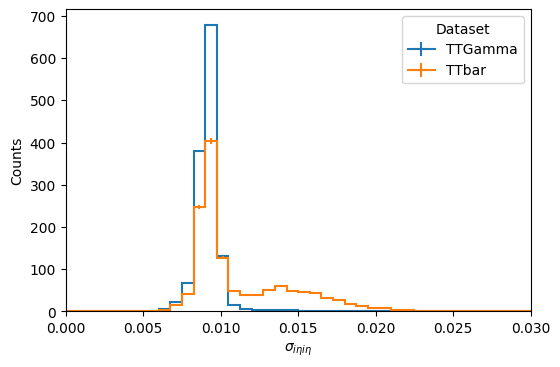

In [10]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_sieie_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon R9</div>

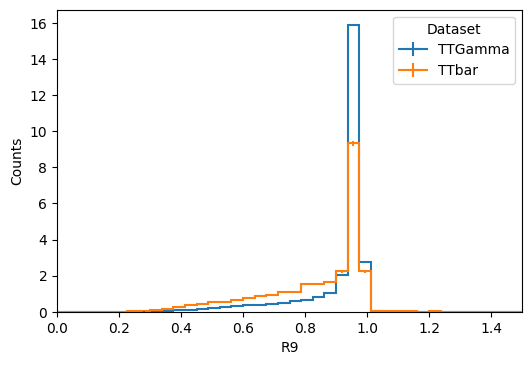

In [11]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_r9_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Photon H over E</div>

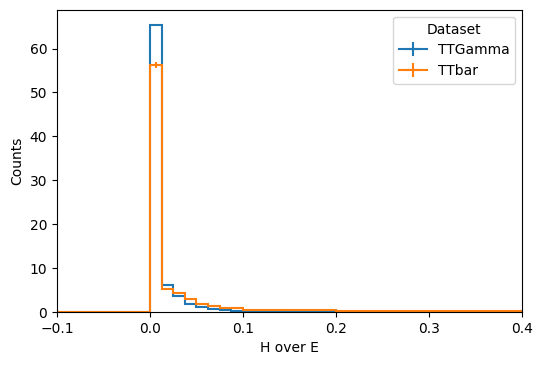

In [12]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_hoe_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">$\Delta R$: Photon to Nearest Muon</div>

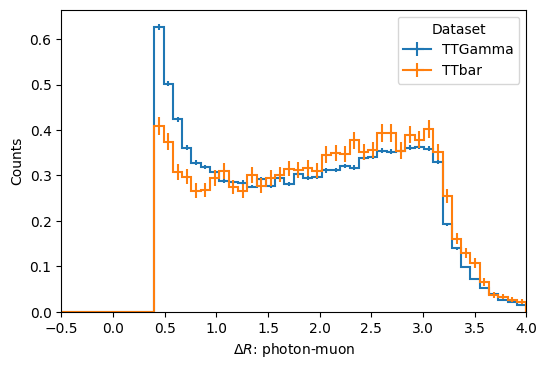

In [13]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">$\Delta R$: Photon to Nearest Jet</div>

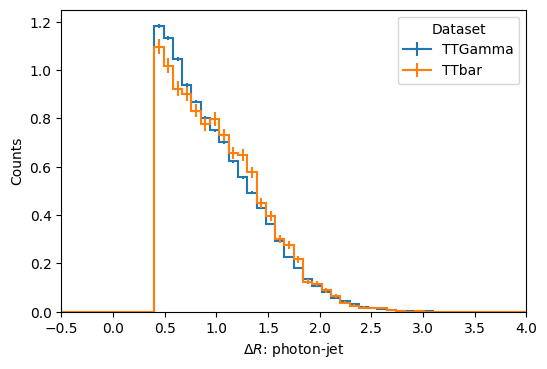

In [14]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True)
plt.show()

### <div align="center">Target: Photon genPartFlav</div>

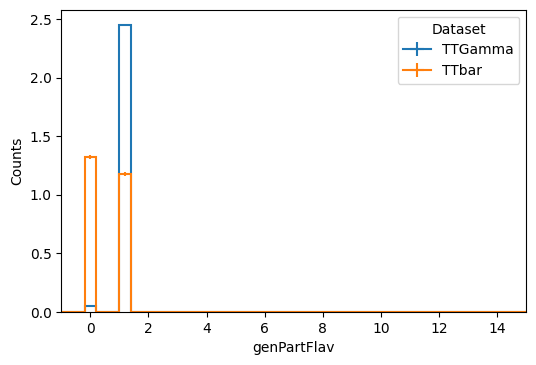

In [15]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True)
plt.show()

In [16]:
# DataFrame of features to be trained on
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    'file': np.array(outputMC['file'].value), # for MVA ID comparison, will remove from training set
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})
# relabel 13 (=prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)

In [17]:
X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [19]:
# remove event type feature from datasets
file_test = X_test['file']

X_train = X_train.drop(['file'],axis=1)
X_test = X_test.drop(['file'],axis=1)
X_val = X_val.drop(['file'],axis=1)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## <div align="center">Machine Learning Model</div>
* Simple neural network using Keras (TensorFlow)
* `Sequential` model with three `Dense` layers: 2 hidden, 1 output

In [21]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=512)

Epoch 1/5
206/206 [==============================] - 1s 3ms/step - loss: 0.2006 - accuracy: 0.9558
Epoch 2/5
206/206 [==============================] - 1s 3ms/step - loss: 0.0896 - accuracy: 0.9744
Epoch 3/5
206/206 [==============================] - 1s 3ms/step - loss: 0.0846 - accuracy: 0.9753
Epoch 4/5
206/206 [==============================] - 1s 3ms/step - loss: 0.0819 - accuracy: 0.9759
Epoch 5/5
206/206 [==============================] - 1s 3ms/step - loss: 0.0803 - accuracy: 0.9761


## <div align="center">Results</div>

Loss and accuracy: call `model.evaluate()` on test dataset

In [23]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.07835
Test accuracy: 0.97693


**ROC curve:**

In [24]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

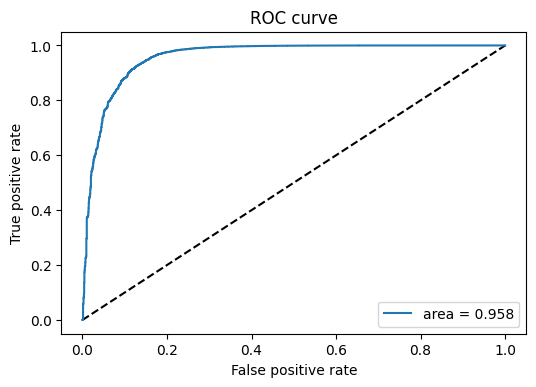

In [25]:
plt.figure(figsize=(6,4),dpi=100)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate');plt.ylabel('True positive rate');plt.title('ROC curve');plt.legend(loc='best');plt.show()

**Distribution of predictions on test dataset:**

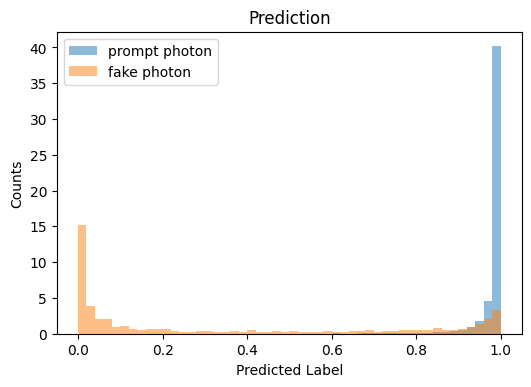

In [26]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]
plt.figure(figsize=(6,4),dpi=100)
plt.hist(predTrue,bins=50,alpha=0.5,density=True,label='prompt photon')
plt.hist(predFalse,bins=50,alpha=0.5,density=True,label='fake photon')
plt.xlabel('Predicted Label');plt.ylabel('Counts');plt.title('Prediction');plt.legend(loc='best');plt.show()

## <div align="center">Alternative Data Processing</div>

Keeping photons with $\Delta R < 0.4$:

In [31]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        # data is/isn't Monte-Carlo
        self.isMC = isMC

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","$\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","pfRelIso03_all", 40, -0.5, 2)
        photon_reliso_chg_axis = hist.Bin("reliso","pfRelIso03_chg", 40, -0.5, 2)
        photon_sieie_axis = hist.Bin("sieie","sigma Ieta Ieta", 40, 0, 0.03)
        photon_r9_axis = hist.Bin("r9","R9", 40, 0, 1.5)
        photon_hoe_axis = hist.Bin("hoe","H over E", 40, -0.1, 0.4)

        mu_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-muon", 50, -0.5, 4)
        jet_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-jet", 50, -0.5, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
            'file': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, mu_deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, jet_deltar_axis),
            
            'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed)
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        # fill histograms
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
        output['photon_eta_hist'].fill(dataset=dataset,
                                       eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
        output['photon_phi_hist'].fill(dataset=dataset,
                                       phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                         sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                       hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                                 deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                              deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid_hist'].fill(dataset=dataset,
                                         mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
        if self.isMC:
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        
        # fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
            
        # dataset labels
        if dataset=='TTGamma':
            output['file'] = processor.column_accumulator(np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        elif dataset=='TTbar':
            output['file'] = processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        else:
            output['file'] = processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [32]:
outputMC_noDR = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)
outputData_noDR = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
)

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

**Compare distributions for $\Delta R$ feature:**

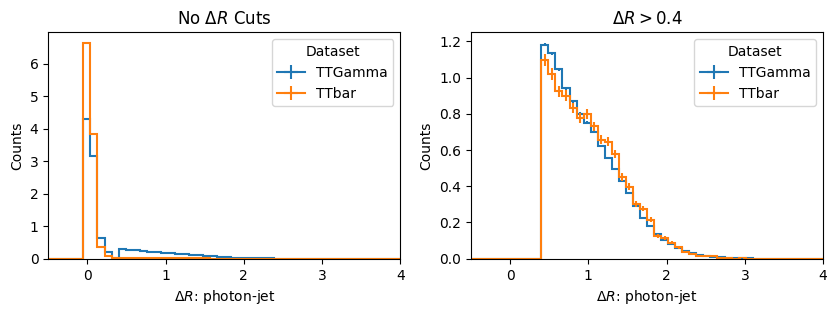

In [42]:
fig, axs = plt.subplots(1,2,figsize=(10,3),dpi=100)
hist.plot1d(outputMC_noDR['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True,ax=axs[0])
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True,ax=axs[1])
axs[0].set_title("No $\Delta R$ Cuts");axs[1].set_title("$\Delta R > 0.4$");plt.show()

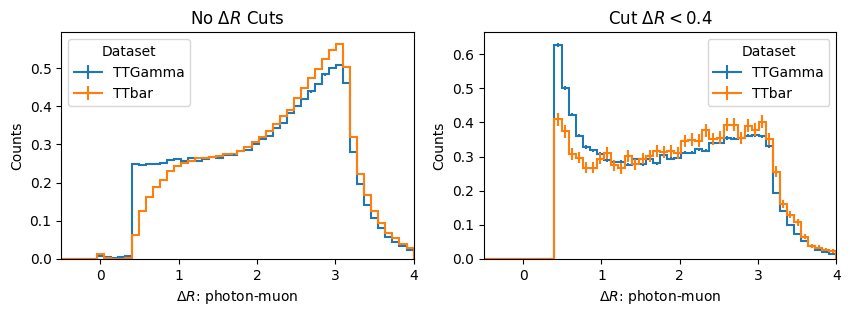

In [34]:
fig, axs = plt.subplots(1,2,figsize=(10,3),dpi=100)
hist.plot1d(outputMC_noDR['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True,ax=axs[0])
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True,ax=axs[1])
axs[0].set_title("No $\Delta R$ Cuts");axs[1].set_title("Cut $\Delta R < 0.4$");plt.show()

**Compare labels:**

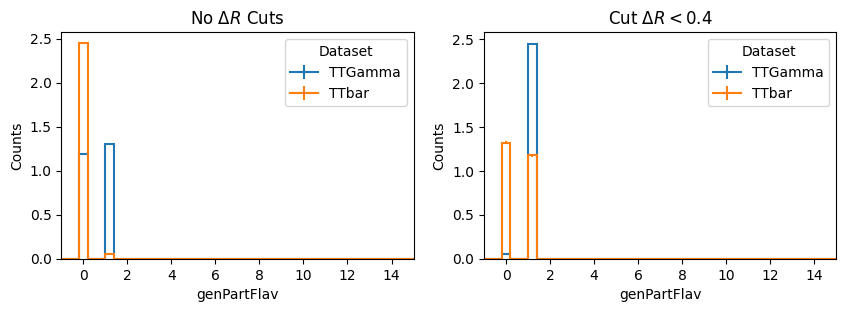

In [35]:
fig, axs = plt.subplots(1,2,figsize=(10,3),dpi=100)
hist.plot1d(outputMC_noDR['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True,ax=axs[0])
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True,ax=axs[1])
axs[0].set_title("No $\Delta R$ Cuts");axs[1].set_title("Cut $\Delta R < 0.4$");plt.show()

**Compare ROC curve:**

In [36]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC_noDR['photon_pt'].value),
    'photon_eta': np.array(outputMC_noDR['photon_eta'].value),
    'photon_phi': np.array(outputMC_noDR['photon_phi'].value),
    'photon_hoe': np.array(outputMC_noDR['photon_hoe'].value),
    'photon_r9': np.array(outputMC_noDR['photon_r9'].value),
    'photon_sieie': np.array(outputMC_noDR['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC_noDR['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC_noDR['photon_pfRelIso03_chg'].value),
    'deltaR_photon_lepton': np.array(outputMC_noDR['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC_noDR['deltaR_photon_jet'].value),
    'file': np.array(outputMC_noDR['file'].value), # for MVA ID comparison, will remove from training set
    'photon_genPartFlav': np.array(outputMC_noDR['photon_genPartFlav'].value), ## TARGET ##
})
# relabel 13 (prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
### split into train, val, test datasets ###
X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']
# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
# remove event type feature from datasets
file_test = X_test['file']
X_train = X_train.drop(['file'],axis=1)
X_test = X_test.drop(['file'],axis=1)
X_val = X_val.drop(['file'],axis=1)
# Scale: mean=0, stdev=1
scaler_noDR = StandardScaler()
X_train_scaled = scaler_noDR.fit_transform(X_train)
X_val_scaled = scaler_noDR.fit_transform(X_val)
X_test_scaled = scaler_noDR.fit_transform(X_test)

In [37]:
model_noDR = Sequential()
model_noDR.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model_noDR.add(Dense(32, activation="relu"))
model_noDR.add(Dense(1,activation="sigmoid"))
model_noDR.compile("adam", "binary_crossentropy", metrics=["accuracy"])

model_noDR.fit(X_train_scaled, y_train, epochs=5, batch_size=512)

Epoch 1/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1631 - accuracy: 0.9389
Epoch 2/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1280 - accuracy: 0.9524
Epoch 3/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1236 - accuracy: 0.9538
Epoch 4/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1212 - accuracy: 0.9547
Epoch 5/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1194 - accuracy: 0.9553


In [38]:
y_pred_noDR = model_noDR.predict(X_test_scaled)
fpr_noDR, tpr_noDR, thresholds_noDR = roc_curve(y_test, y_pred_noDR)
area_under_curve_noDR = auc(fpr_noDR, tpr_noDR)

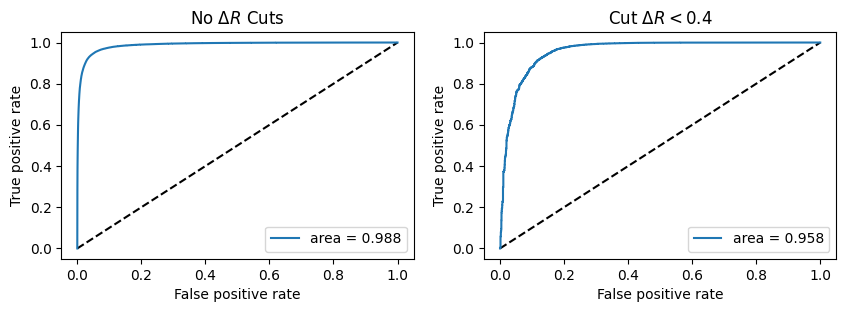

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,3),dpi=100)
axs[0].plot([0,1], [0,1], 'k--');axs[0].plot(fpr_noDR, tpr_noDR, label='area = {:.3f}'.format(area_under_curve_noDR))
axs[0].set_xlabel('False positive rate');axs[0].set_ylabel('True positive rate');axs[0].legend(loc='best');axs[0].set_title("No $\Delta R$ Cuts")
axs[1].plot([0,1], [0,1], 'k--');axs[1].plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))
axs[1].set_xlabel('False positive rate');axs[1].set_ylabel('True positive rate');axs[1].legend(loc='best');axs[1].set_title("Cut $\Delta R < 0.4$");plt.show()

**Compare predictions:**

In [40]:
predTrue_noDR  = y_pred_noDR[y_test==True]
predFalse_noDR = y_pred_noDR[y_test==False]

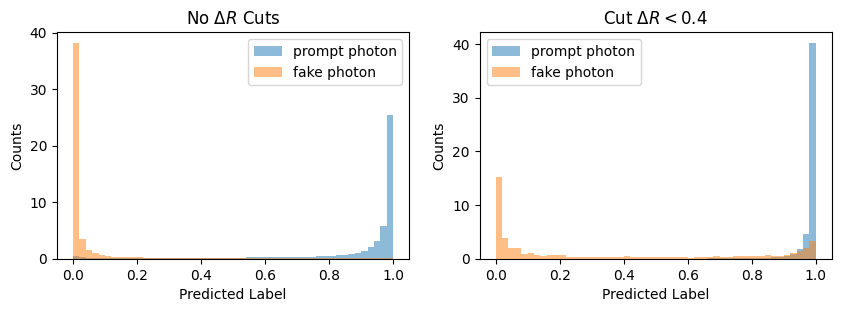

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,3),dpi=100)
axs[0].hist(predTrue_noDR,bins=50,density=True,alpha=0.5,label='prompt photon')
axs[0].hist(predFalse_noDR,bins=50,density=True,alpha=0.5,label='fake photon')
axs[0].set_xlabel('Predicted Label');axs[0].set_ylabel('Counts');axs[0].set_title("No $\Delta R$ Cuts");axs[0].legend(loc='best')
axs[1].hist(predTrue,bins=50,density=True,alpha=0.5,label='prompt photon')
axs[1].hist(predFalse,bins=50,density=True,alpha=0.5,label='fake photon')
axs[1].set_xlabel('Predicted Label');axs[1].set_ylabel('Counts');axs[1].set_title("Cut $\Delta R < 0.4$");axs[1].legend(loc='best');plt.show()

# <div align="center">Summary</div>
* Test accuracy: 0.976, AUC: 0.958
* Accurately predicts label for prompt photons
* Misclassifies some fake photons when cutting $\Delta R < 0.4$

# <div align="center">Future Steps</div>
* Resolve misclassified fake photons
* Optimize model parameters